<a href="https://colab.research.google.com/github/Fayjul/Machine-Learning/blob/master/ML_project_brain_tumar_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

In [2]:
data = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/ML_data/brain_tumor_dataset")

Found 253 files belonging to 2 classes.


In [3]:
batch = data.as_numpy_iterator().next()


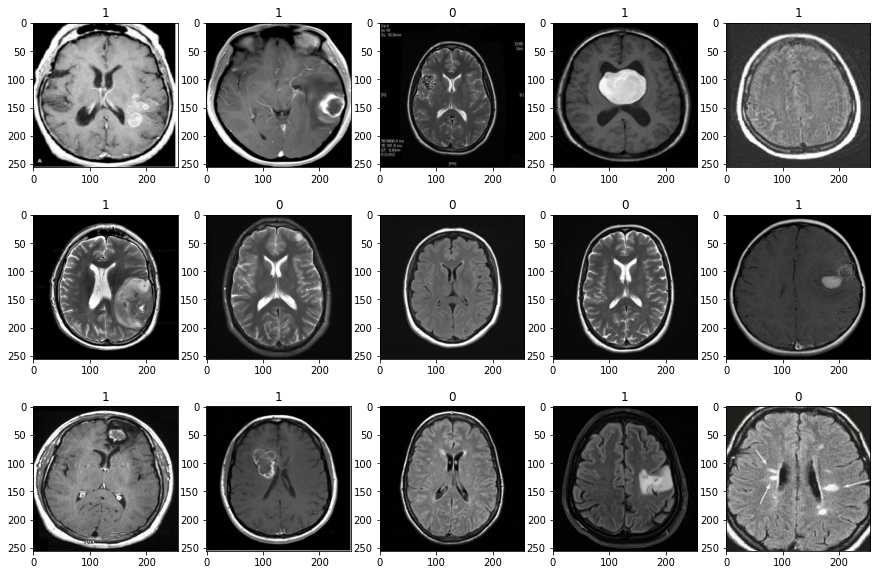

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
data = data.map(lambda x,y: (x/255, y))

In [6]:
batch = data.as_numpy_iterator().next()

In [7]:
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())

Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0


In [8]:
print("There are", len(data), "batches in our data")

There are 8 batches in our data


In [9]:
train_size = int(len(data)*0.6)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.2)+1

In [10]:
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

print("Sum of Train, Validation and Test sizes is equal to:", train_size + val_size + test_size)

Train Size: 4
Validation Size: 2
Test Size: 2
Sum of Train, Validation and Test sizes is equal to: 8


In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [12]:
batch = data.as_numpy_iterator().next()

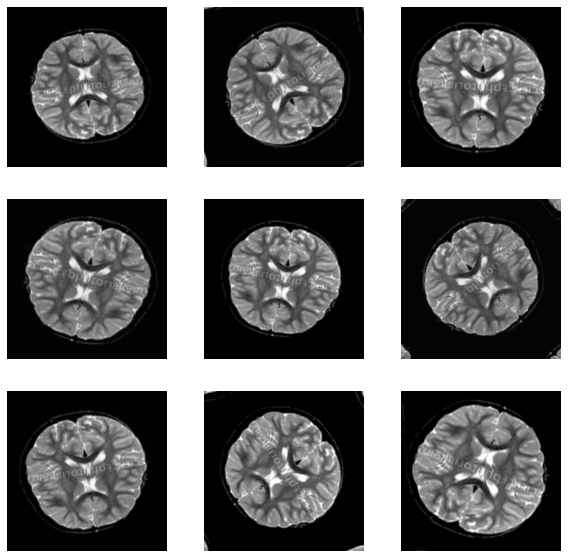

In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256,256,3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

image = batch[0]


plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")


In [14]:
model = Sequential([
    data_augmentation,
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    Conv2D(32, (5,5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    Conv2D(16, (3,3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [15]:
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      25632     
                                                      

In [17]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15


4/4 [==============================] - 40s 9s/step - loss: 0.6832 - accuracy: 0.4922 - val_loss: 0.5653 - val_accuracy: 0.6719
Epoch 2/15
4/4 [==============================] - 40s 10s/step - loss: 0.5863 - accuracy: 0.7344 - val_loss: 0.5661 - val_accuracy: 0.6719
Epoch 3/15
4/4 [==============================] - 36s 9s/step - loss: 0.6479 - accuracy: 0.6094 - val_loss: 0.6390 - val_accuracy: 0.8125
Epoch 4/15
4/4 [==============================] - 36s 9s/step - loss: 0.6100 - accuracy: 0.7266 - val_loss: 0.5995 - val_accuracy: 0.7656
Epoch 5/15
4/4 [==============================] - 36s 9s/step - loss: 0.5881 - accuracy: 0.6328 - val_loss: 0.5591 - val_accuracy: 0.7500
Epoch 6/15
4/4 [==============================] - 36s 9s/step - loss: 0.6011 - accuracy: 0.7344 - val_loss: 0.5652 - val_accuracy: 0.7812
Epoch 7/15
4/4 [==============================] - 38s 10s/step - loss: 0.5471 - accuracy: 0.7500 - val_loss: 0.5348 - val_accuracy: 0.7500
Epoch 8/15
4/4 [===========================

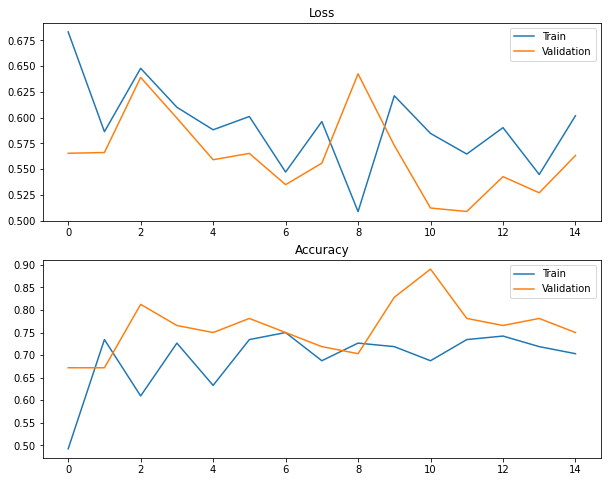

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [19]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

print("Accuracy:", bin_acc.result().numpy(), "\nRecall:", recall.result().numpy(), "\nPrecision:", precision.result().numpy())

1/1 [==============================] - 2s 2s/step
Accuracy: 0.78688526 
Recall: 0.775 
Precision: 0.8857143


In [20]:
batch = test.as_numpy_iterator().next()

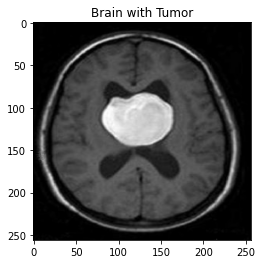

In [21]:
img, label = batch[0][15], batch[1][15]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [22]:
y_hat = model.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 84ms/step


In [23]:
y_hat

array([[0.67532927]], dtype=float32)

In [24]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

Tumor detected


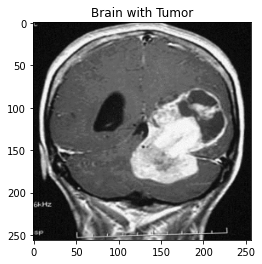

In [25]:
img, label = batch[0][19], batch[1][19]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [26]:
y_hat = model.predict(np.expand_dims(img, 0))
y_hat

1/1 [==============================] - 0s 80ms/step


array([[0.8680207]], dtype=float32)

In [27]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

Tumor detected


In [ ]:
from google.colab import files


img, label =files.upload(), model.predict(np.expand_dims(img, 0))

if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()


Saving 1 no.jpeg to 1 no (3).jpeg


ValueError: ignored

In [ ]:
img, label = 'N26.JPG', 0

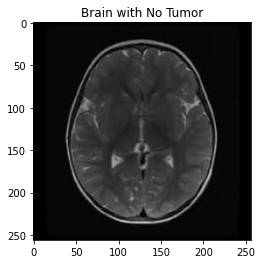

In [ ]:
img, label = batch[0][19], batch[1][19]
plt.imshow(img)
if label==1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()

In [ ]:
y_hat = model.predict(np.expand_dims(img, 0))
y_hat

array([[0.47590002]], dtype=float32)

In [ ]:
if y_hat < 0.5:
    print("No tumor detected")
else:
    print("Tumor detected")

No tumor detected
